# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

# HOMEWORK 3 - Deep Reinforcement Learning - Notebook 2/2

**FRANCESCO FONTANA -  matricola 2026924**

# "***LunarLander-v2***"

In [ ]:
!apt -qq update
!apt-get -qq install python-opengl -y
!apt -qq install xvfb -y --quiet
!pip install pyvirtualdisplay --quiet
!pip install piglet --quiet

W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease' is no longer signed.


In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!pip3 install box2d-py --quiet
!pip3 install gym[Box_2D] --quiet

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, action_space_dim)
                )
    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=8, action_space_dim=4)
net

DQN(
  (linear): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

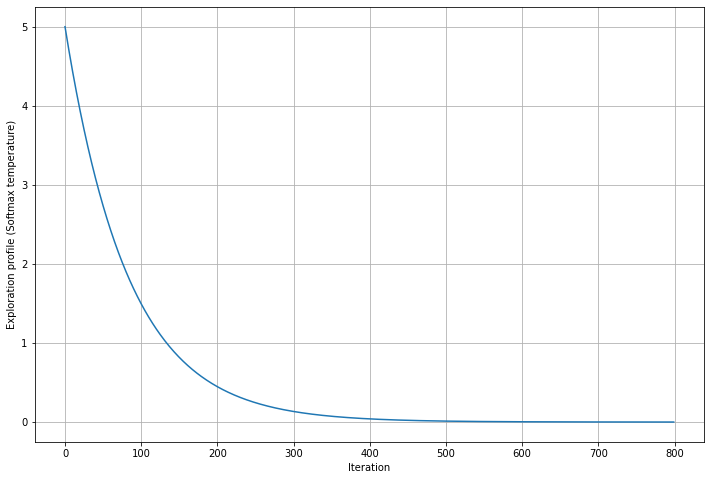

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 900
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)] # softmax

#exploration_profile = np.concatenate([np.repeat(0.5,100),np.repeat(0.3,100),np.repeat(0.15,150),np.repeat(0.08,200), np.repeat(0.001,200), np.repeat(0.0001,400)]) #epsilon-greedy

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [ ]:
### Create environment
env = gym.make('LunarLander-v2') # Initialize the Gym environment
env.seed(2026924) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


In [ ]:
# Define the network
net = DQN(state_space_dim=state_space_dim, action_space_dim=action_space_dim)
net

DQN(
  (linear): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

# Training 

In [ ]:
net

DQN(
  (linear): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(2026924)
np.random.seed(2026924)
random.seed(2026924)

### PARAMETERS
gamma = 0.98                    # gamma parameter for the long term reward
replay_memory_capacity = 10000    # Replay memory capacity
lr = 0.1                         # Optimizer learning rate
target_net_update_steps = 20      # Number of episodes to wait before updating the target network
batch_size = 128                  # Number of samples to take from the replay memory for each update
bad_state_penalty = 0         # Penalty to the reward when we are in a bad state (in this case when the spacecraft falls down the landing zone) 
min_samples_for_training = 1000  
adaptive_learnig_rate=True

pos_weight=1

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 900
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.MSELoss()


In [ ]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(2026924) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

results_1 = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      #action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the spacecraft is far from origin
      reward = reward - pos_weight * np.abs(state[0])
      reward = reward - pos_weight * np.abs(state[1])

      # We apply a (linear) penalty when the spacecraft is tilted with an angle != 0
      #reward = reward - pos_weight * np.abs(state[4])
      
      # Update the final score (+1 for each step)
      score += reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    results_2.append(score)

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

    # EARLY STOPPING stopping
    if np.mean(results_1[episode_num-30:])>=200 : break

    # ADAPTIVE LEARNING RATE
    if adaptive_learnig_rate == True:

      if optimizer.param_groups[0]['lr'] == lr/150  or np.mean(results_1[-10:]) >= 170:   #last episodes reach score=180:
          optimizer.param_groups[0]['lr'] = lr/150

      elif optimizer.param_groups[0]['lr'] == lr/100 or np.mean(results_1[-10:]) >= 120:  #last episodes reach score=150:
        optimizer.param_groups[0]['lr'] = lr/100

      elif optimizer.param_groups[0]['lr'] == lr/50 or np.mean(results_1[-10:]) >= 70:   #last episodes reach score=70:
              optimizer.param_groups[0]['lr'] = lr/50

      elif optimizer.param_groups[0]['lr'] == lr/10 or np.mean(results_1[-10:]) >= -20:   #last episodes reach score=40:
        optimizer.param_groups[0]['lr'] = lr/10


env.close()

  0%|          | 0/900 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -395.5044680720399 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -84.80720616217128 - Temperature: 4.946638853023665
EPISODE: 3 - FINAL SCORE: -170.89629703022564 - Temperature: 4.893847188448656
EPISODE: 4 - FINAL SCORE: -206.5909479596633 - Temperature: 4.841618928628149
EPISODE: 5 - FINAL SCORE: -385.36942322916946 - Temperature: 4.789948060777363
EPISODE: 6 - FINAL SCORE: -97.30184708662401 - Temperature: 4.738828636281332
EPISODE: 7 - FINAL SCORE: 23.823395936724054 - Temperature: 4.688254770010078
EPISODE: 8 - FINAL SCORE: -125.5400702632264 - Temperature: 4.638220639641075
EPISODE: 9 - FINAL SCORE: -203.18669963754857 - Temperature: 4.588720484988963
EPISODE: 10 - FINAL SCORE: -133.1329843407001 - Temperature: 4.539748607342401
EPISODE: 11 - FINAL SCORE: -80.41927424171183 - Temperature: 4.491299368807998
EPISODE: 12 - FINAL SCORE: -298.6398757580969 - Temperature: 4.443367191661261
EPISODE: 13 - FINAL SCORE: -221.037810828163 

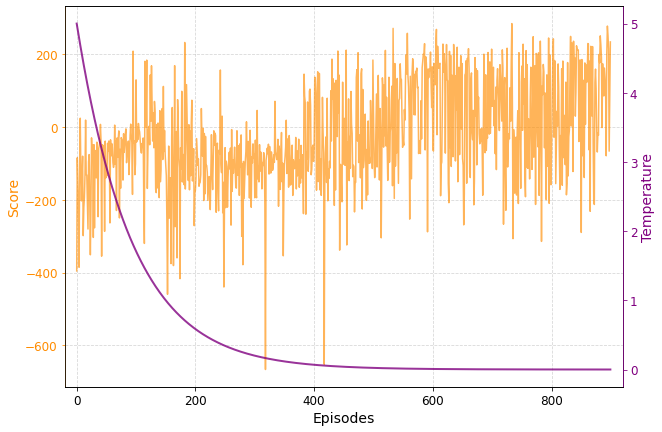

In [ ]:
color1="darkorange"
color2 = "purple"

fig, ax = plt.subplots(figsize = (10,7))
ax.plot(results_2, color = color1, alpha = 0.65)

ax.set_xlabel("Episodes", size = 14)
ax.set_ylabel("Score", size = 14, color=color1)
ax.set_xlim(-20, len(results_2)+20)
ax.grid(axis = "both", alpha = 0.5, linestyle = "--")

# coloring right Y-axis
ax.spines['left'].set_color(color1)
ax.tick_params(axis='y', colors=color1, labelsize=12)
ax.tick_params(axis='x',labelsize=12)


ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(np.array(exploration_profile) ,color=color2, alpha =0.8, linewidth=2, label="Temperature")
ax2.set_ylabel("Temperature",color=color2,fontsize=14)

# coloring right Y-axis
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2, labelsize=12)
plt.show()

fig.savefig("LL_train_score_ADAPT_lr01_g098_bs128_ADAM_huber_pw01_bs0.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)


# BEST RESULT

In [ ]:
# Set random seeds
torch.manual_seed(2026924)
np.random.seed(2026924)
random.seed(2026924)

### PARAMETERS
gamma = 0.99                      # gamma parameter for the long term reward
replay_memory_capacity = 10000    # Replay memory capacity
lr = 0.001                        # Optimizer learning rate
target_net_update_steps = 10      # Number of episodes to wait before updating the target network
batch_size = 256                  # Number of samples to take from the replay memory for each update
bad_state_penalty = 0             # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000 

adaptive_learnig_rate=False

pos_weight=1

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.MSELoss()

In [ ]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(2026924) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

results_1 = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      #action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      
      # We apply a (linear) penalty when the spacecraft is far from origin
      #reward = reward - pos_weight * np.abs(state[0])
      #reward = reward - pos_weight * np.abs(state[1])

      # We apply a (linear) penalty when the spacecraft is tilted with an angle != 0
      reward = reward - pos_weight * np.abs(state[4])

      # Update the final score (+1 for each step)
      score += reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    results_1.append(score)

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

    # EARLY STOPPING stopping
    if np.mean(results_1[episode_num-30:])>=200 : break

     # ADAPTIVE LEARNING RATE
    if adaptive_learnig_rate == True:

      if optimizer.param_groups[0]['lr'] == lr/25  or results_1[-1] >= 180:   #last episodes reach score=180:
          optimizer.param_groups[0]['lr'] = lr/25

      elif optimizer.param_groups[0]['lr'] == lr/15 or results_1[-1] >= 150:  #last episodes reach score=150:
        optimizer.param_groups[0]['lr'] = lr/15

      elif optimizer.param_groups[0]['lr'] == lr/10 or results_1[-1] >= 70:   #last episodes reach score=70:
              optimizer.param_groups[0]['lr'] = lr/10

      elif optimizer.param_groups[0]['lr'] == lr/5 or results_1[-1] >= 40:   #last episodes reach score=40:
        optimizer.param_groups[0]['lr'] = lr/5

      if episode_num % target_net_update_steps == 0:
          print("\t\t\t\t\t\t\t Learning rate:", optimizer.param_groups[0]['lr'])

env.close()

  0%|          | 0/800 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -384.7387453423492 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -76.85443234375106 - Temperature: 4.940008876649582
EPISODE: 3 - FINAL SCORE: -150.36488312129427 - Temperature: 4.880737540275333
EPISODE: 4 - FINAL SCORE: -189.93862760104054 - Temperature: 4.822177354711398
EPISODE: 5 - FINAL SCORE: -371.3755964686316 - Temperature: 4.764319787410582
EPISODE: 6 - FINAL SCORE: -87.4435171103671 - Temperature: 4.707156408201104
EPISODE: 7 - FINAL SCORE: 31.134504205172192 - Temperature: 4.650678888058284
EPISODE: 8 - FINAL SCORE: -117.99726526832669 - Temperature: 4.594878997890946
EPISODE: 9 - FINAL SCORE: -194.8901016775393 - Temperature: 4.539748607342402
EPISODE: 10 - FINAL SCORE: -119.62819876451678 - Temperature: 4.485279683605809


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


Updating target network...
EPISODE: 11 - FINAL SCORE: -70.48395207617833 - Temperature: 4.431464290253745
EPISODE: 12 - FINAL SCORE: -85.79481707499347 - Temperature: 4.378294586081827
EPISODE: 13 - FINAL SCORE: -313.2979765286484 - Temperature: 4.325762823966207
EPISODE: 14 - FINAL SCORE: -101.85833889619086 - Temperature: 4.273861349734766
EPISODE: 15 - FINAL SCORE: -299.7187141362966 - Temperature: 4.222582601051861
EPISODE: 16 - FINAL SCORE: -394.3284591565941 - Temperature: 4.171919106316454
EPISODE: 17 - FINAL SCORE: -71.01416943828477 - Temperature: 4.121863483573455
EPISODE: 18 - FINAL SCORE: -34.60029172426097 - Temperature: 4.072408439438128
EPISODE: 19 - FINAL SCORE: -385.84409926790477 - Temperature: 4.0235467680334045
EPISODE: 20 - FINAL SCORE: -65.01006999347092 - Temperature: 3.975271349939951
Updating target network...
EPISODE: 21 - FINAL SCORE: -142.01088815286485 - Temperature: 3.9275751511588246
EPISODE: 22 - FINAL SCORE: -91.19617117932107 - Temperature: 3.880451222

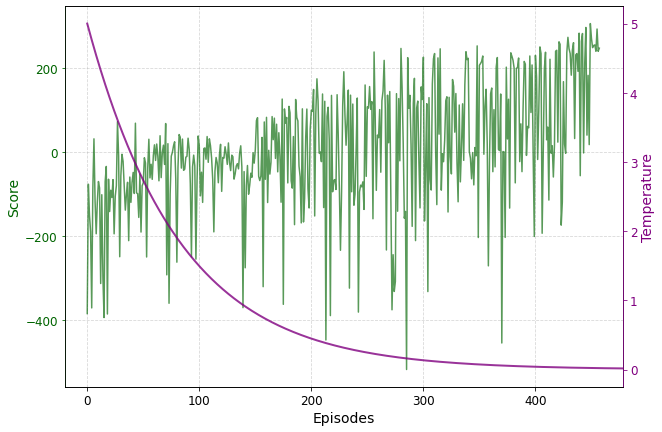

In [ ]:
color1="darkgreen"
color2 = "purple"

fig, ax = plt.subplots(figsize = (10,7))
ax.plot(results_1, color = color1, alpha = 0.65)

ax.set_xlabel("Episodes", size = 14)
ax.set_ylabel("Score", size = 14, color=color1)
ax.set_xlim(-20, len(results_1)+20)
ax.grid(axis = "both", alpha = 0.5, linestyle = "--")

# coloring right Y-axis
ax.spines['left'].set_color(color1)
ax.tick_params(axis='y', colors=color1, labelsize=12)
ax.tick_params(axis='x',labelsize=12)


ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(np.array(exploration_profile) ,color=color2, alpha =0.8, linewidth=2, label="Temperature")
ax2.set_ylabel("Temperature",color=color2,fontsize=14)

# coloring right Y-axis
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2, labelsize=12)
plt.show()

fig.savefig("LL_train_score_NOadapt_lr0001_g099_bs256_pw0_adam_huber.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

# FINAL OUTPUT (10 times + video)

In [ ]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(2026924) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 5 episodes
for num_episode in range(5): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.12.37956.video000000.mp4



SHOWING VIDEO video/openaigym.video.12.37956.video000001.mp4



SHOWING VIDEO video/openaigym.video.12.37956.video000002.mp4



SHOWING VIDEO video/openaigym.video.12.37956.video000003.mp4



SHOWING VIDEO video/openaigym.video.12.37956.video000004.mp4
